In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [ ]:
# ! wget https://raw.githubusercontent.com/TemaBlag/Yandex_Training/main/ml_training_3/hw5/train.csv
# ! wget https://raw.githubusercontent.com/TemaBlag/Yandex_Training/main/ml_training_3/hw5/test.csv

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [ ]:
df_train.shape

(1288, 17)

In [ ]:
df_train.head()

,area,perimeter,major_axis,minor_axis,eccentricity,eqdiasq,solidity,convex_area,extent,aspect_ratio,roundness,compactness,shapefactor_1,shapefactor_2,shapefactor_3,shapefactor_4,target
0,75516,1731.4840,411.7352,245.7620,0.8023,310.0806,0.9148,82546,0.7169,1.6753,0.3165,0.7531,0.0055,0.0033,0.5672,0.9502,1
1,98903,1374.4370,477.2451,269.7676,0.8249,354.8622,0.9585,103181,0.7679,1.7691,0.6579,0.7436,0.0048,0.0027,0.5529,0.9781,0
2,84746,1311.1570,482.7735,235.9040,0.8725,328.4843,0.9121,92914,0.7162,2.0465,0.6195,0.6804,0.0057,0.0028,0.4630,0.9474,1
3,98184,1463.1680,434.3769,292.6472,0.7390,353.5700,0.9543,102890,0.7316,1.4843,0.5763,0.8140,0.0044,0.0030,0.6625,0.9834,0
4,94170,1267.7271,440.1109,278.4162,0.7745,346.2672,0.9643,97656,0.6836,1.5808,0.7363,0.7868,0.0047,0.0030,0.6190,0.9785,0


In [ ]:
df_train.isna().sum()

,0
area,0
perimeter,0
major_axis,0
minor_axis,0
eccentricity,0
eqdiasq,0
solidity,0
convex_area,0
extent,0
aspect_ratio,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df_train.drop(columns='target')
y = df_train['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

## Baseline

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
model.fit(x_train_norm, y_train)

y_pred = model.predict(x_test_norm)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8604651162790697


## Catboost

In [ ]:
# ! pip install catboost

In [ ]:
import catboost
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=1000,      # сколько деревьев
    learning_rate=0.1,    # скорость обучения
    depth=6,              # глубина деревьев
    eval_metric='Accuracy', # метрика для валидации
    verbose=100           # выводить лог каждые 100 итераций
)

model.fit(x_train_norm, y_train, eval_set=(x_test_norm, y_test), early_stopping_rounds=100)

0:	learn: 0.8601942	test: 0.8604651	best: 0.8604651 (0)	total: 5.25ms	remaining: 5.25s
100:	learn: 0.9650485	test: 0.8643411	best: 0.8682171 (92)	total: 534ms	remaining: 4.75s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8682170543
bestIteration = 92

Shrink model to first 93 iterations.


In [ ]:
y_pred = model.predict(x_test_norm)

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8682170542635659


In [ ]:
model.get_feature_importance()

array([ 4.84380498,  4.32221351,  5.3485225 ,  7.45771523,  3.98296599,
        5.84377718,  6.78647806,  6.82572009,  7.68919654,  5.0813057 ,
        6.52007056,  5.06521019, 10.35060351,  1.56910602,  6.9095296 ,
       11.40378034])

## Подбор гиперпарамтеров

In [ ]:
# ! pip install optuna

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'iterations': trial.suggest_int('iterations', 500, 1500),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 2),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'random_strength': trial.suggest_float('random_strength', 1e-9, 10),
        'verbose': 0,
        'random_seed': 42
    }

    model = CatBoostClassifier(**params)
    score = cross_val_score(model, X, y, scoring='accuracy', cv=3).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(study.best_params)


[I 2025-04-26 20:23:59,623] A new study created in memory with name: no-name-136191ab-1791-4e4d-8748-66c460457273
[I 2025-04-26 20:24:34,257] Trial 0 finished with value: 0.8649120904934859 and parameters: {'depth': 8, 'learning_rate': 0.160655565525162, 'iterations': 1177, 'l2_leaf_reg': 6.339233335543313, 'bagging_temperature': 0.20311643105228572, 'border_count': 110, 'random_strength': 1.1281492649159823}. Best is trial 0 with value: 0.8649120904934859.
[I 2025-04-26 20:24:48,836] Trial 1 finished with value: 0.8641260548237293 and parameters: {'depth': 8, 'learning_rate': 0.2795293818484768, 'iterations': 658, 'l2_leaf_reg': 4.564917587128414, 'bagging_temperature': 1.8038967348993573, 'border_count': 114, 'random_strength': 6.6732706533586486}. Best is trial 0 with value: 0.8649120904934859.
[I 2025-04-26 20:24:55,016] Trial 2 finished with value: 0.8618167362353408 and parameters: {'depth': 5, 'learning_rate': 0.14425327602162744, 'iterations': 741, 'l2_leaf_reg': 3.646166481098

{'depth': 9, 'learning_rate': 0.013474519950993427, 'iterations': 571, 'l2_leaf_reg': 5.556522643022767, 'bagging_temperature': 0.4847632351487044, 'border_count': 208, 'random_strength': 2.4587408499630583}


In [ ]:
import optuna
import numpy as np
from catboost import CatBoostClassifier, Pool


feature_names = X.columns.tolist()

def objective(trial):
    params = {
        "iterations": 10000,
        "early_stopping_rounds": 100,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1, 10),
        "loss_function": "Logloss",
        "eval_metric": "Accuracy",
        "verbose": 0,
        "task_type": "GPU",
        "devices": "0"
    }

    model = CatBoostClassifier(**params)

    # Обучаем модель
    model.fit(x_train_norm, y_train, eval_set=(x_test_norm, y_test), use_best_model=True)

    preds = model.predict(x_test_norm)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("\nЛучшие параметры:")
print(study.best_params)
print("\nЛучшая точность:", study.best_value)


[I 2025-04-26 20:53:11,339] A new study created in memory with name: no-name-78986c58-bbd5-4795-9bcc-8e4ef4f5449c
[I 2025-04-26 20:53:14,356] Trial 0 finished with value: 0.8604651162790697 and parameters: {'depth': 5, 'learning_rate': 0.045272466382665265, 'l2_leaf_reg': 9.115523150728121, 'bagging_temperature': 0.746366364915276, 'random_strength': 5.449514247357252}. Best is trial 0 with value: 0.8604651162790697.
[I 2025-04-26 20:53:44,819] Trial 1 finished with value: 0.8604651162790697 and parameters: {'depth': 10, 'learning_rate': 0.06216291024989967, 'l2_leaf_reg': 7.843710861274478, 'bagging_temperature': 0.944327367193749, 'random_strength': 2.188217408277361}. Best is trial 0 with value: 0.8604651162790697.
[I 2025-04-26 20:53:52,059] Trial 2 finished with value: 0.8604651162790697 and parameters: {'depth': 8, 'learning_rate': 0.04387300338709352, 'l2_leaf_reg': 1.5945893858336906, 'bagging_temperature': 0.6327092644026538, 'random_strength': 1.3086402863714661}. Best is tri


Лучшие параметры:
{'depth': 8, 'learning_rate': 0.07467512885213419, 'l2_leaf_reg': 4.579248740631226, 'bagging_temperature': 0.22503495936094642, 'random_strength': 8.038749733809894}

Лучшая точность: 0.875968992248062


## Создание полиномиальных признаков (квадратичных)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

x_train_poly = poly.fit_transform(x_train)
x_test_poly = poly.transform(x_test)

x_train_poly = np.hstack([x_train, x_train_poly])
x_test_poly = np.hstack([x_test, x_test_poly])

In [ ]:
x_train_poly.shape

(1030, 168)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

scaler = StandardScaler()
df_train_poly_scaled = scaler.fit_transform(x_train_poly)
df_test_poly_scaled = scaler.transform(x_test_poly)

pca = PCA(n_components=30)
df_train_pca = pca.fit_transform(df_train_poly_scaled)
df_test_pca = pca.transform(df_test_poly_scaled)

df_train_pca = pd.DataFrame(df_train_pca, columns=[f"PC{i+1}" for i in range(30)])
df_test_pca = pd.DataFrame(df_test_pca, columns=[f"PC{i+1}" for i in range(30)])

print(df_train_pca.head())

         PC1       PC2        PC3       PC4       PC5       PC6       PC7  \
0  12.120131  0.057488 -11.791924 -0.849301 -0.974745 -0.197336  1.739145   
1   2.698781 -3.204377 -12.224059  0.530703 -1.719710 -0.137208 -0.042690   
2  -0.251102 -9.056472   6.279971 -0.483540 -2.317425  0.812963  0.083169   
3  11.566232  1.667467  -7.723755 -0.973811 -1.457143  0.210376  1.037748   
4   8.437343  7.523172   2.977514 -1.777060 -0.284277  0.333730  0.656276   

        PC8       PC9      PC10  ...      PC21      PC22      PC23      PC24  \
0  0.245132 -0.491380  0.626683  ...  0.022717  0.144169  0.005961 -0.101968   
1 -0.624833 -0.663961  0.217494  ... -0.126023  0.017247 -0.010745 -0.022938   
2 -0.410632  0.713092 -0.346159  ...  0.132326 -0.033217  0.077995  0.003248   
3  0.249467 -0.533763  0.014057  ... -0.003637  0.110582  0.002951 -0.066300   
4  0.314635  0.416587  0.471774  ...  0.017707  0.070915  0.016231 -0.002380   

       PC25      PC26      PC27      PC28      PC29     

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=300, max_depth=10, random_state=42)
model.fit(df_train_pca, y_train)

y_pred = model.predict(df_test_pca)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8604651162790697


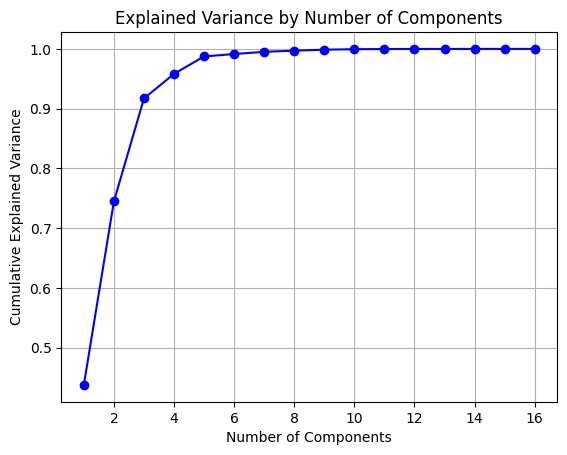

Optimal number of components: 6
        PC1       PC2       PC3       PC4       PC5       PC6
0 -4.229246 -0.076326 -3.199633 -0.539112 -0.302699  0.195221
1 -1.741177 -1.443960 -3.525887 -0.202970 -0.554153 -0.068203
2 -0.211487 -2.369800  2.204929 -0.208721 -0.797822  0.321159
3 -3.768765  0.553140 -2.051230 -0.584229 -0.387449  0.162942
4 -1.891455  2.634643  0.889150 -0.579466  0.021137  0.173937


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

scaler = StandardScaler()
df_train_poly_scaled = scaler.fit_transform(x_train)
df_test_poly_scaled = scaler.transform(x_test)

pca = PCA()
pca.fit(df_train_poly_scaled)

explained_variance_ratio = pca.explained_variance_ratio_

plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio.cumsum(), marker='o', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid(True)
plt.show()

n_components = next(i for i, cumsum in enumerate(pca.explained_variance_ratio_.cumsum()) if cumsum >= 0.99) + 1
print(f"Optimal number of components: {n_components}")

pca = PCA(n_components=n_components)
df_train_pca = pca.fit_transform(df_train_poly_scaled)
df_test_pca = pca.transform(df_test_poly_scaled)

df_train_pca = pd.DataFrame(df_train_pca, columns=[f"PC{i+1}" for i in range(n_components)])
df_test_pca = pd.DataFrame(df_test_pca, columns=[f"PC{i+1}" for i in range(n_components)])

print(df_train_pca.head())


In [ ]:
import optuna
import numpy as np
from catboost import CatBoostClassifier, Pool


feature_names = X.columns.tolist()

def objective(trial):
    params = {
        "iterations": 10000,
        "early_stopping_rounds": 100,
        "depth": trial.suggest_int("depth", 6, 8),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1, 10),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1, 10),
        "loss_function": "Logloss",
        "eval_metric": "Accuracy",
        "verbose": 0,
        "task_type": "GPU",
        "devices": "0"
    }

    model = CatBoostClassifier(**params)

    # Обучаем модель
    model.fit(df_train_pca, y_train, eval_set=(df_test_pca, y_test), use_best_model=True)

    preds = model.predict(df_test_pca)
    accuracy = accuracy_score(y_test, preds)
    return accuracy

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

print("\nЛучшие параметры:")
print(study.best_params)
print("\nЛучшая точность:", study.best_value)


[I 2025-04-26 21:30:38,875] A new study created in memory with name: no-name-9263240e-0d54-4f15-9668-3a29740897f5
[I 2025-04-26 21:30:51,167] Trial 0 finished with value: 0.872093023255814 and parameters: {'depth': 7, 'learning_rate': 0.029983923508322505, 'l2_leaf_reg': 1.8106479075276565, 'bagging_temperature': 0.4982424523369824, 'random_strength': 5.990754742884508}. Best is trial 0 with value: 0.872093023255814.
[I 2025-04-26 21:30:58,747] Trial 1 finished with value: 0.872093023255814 and parameters: {'depth': 7, 'learning_rate': 0.05863605030135984, 'l2_leaf_reg': 6.790555577458529, 'bagging_temperature': 0.8739208589572349, 'random_strength': 5.136025538804162}. Best is trial 0 with value: 0.872093023255814.
[I 2025-04-26 21:31:11,955] Trial 2 finished with value: 0.872093023255814 and parameters: {'depth': 7, 'learning_rate': 0.02270994902780389, 'l2_leaf_reg': 3.665654814363666, 'bagging_temperature': 0.6256866251238505, 'random_strength': 3.1682291956711524}. Best is trial 0


Лучшие параметры:
{'depth': 6, 'learning_rate': 0.06833784255065162, 'l2_leaf_reg': 8.908196106014795, 'bagging_temperature': 0.7477685179197879, 'random_strength': 7.032204265665096}

Лучшая точность: 0.8837209302325582


## Ансамбль моделей (CatBoost, XGBoost, LightGBM) с помощью VotingClassifier

In [ ]:
X_train = df_train.drop(columns=['target'])
y_train = df_train['target']
X_test = df_test.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Генерация полиномиальных признаков степени 2 (PolynomialFeatures)
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)
# Получаем имена новых признаков (для понимания структуры данных)
feature_names = poly.get_feature_names_out(input_features=X_train.columns)
X_train_poly_df = pd.DataFrame(X_train_poly, columns=feature_names)
X_test_poly_df = pd.DataFrame(X_test_poly, columns=feature_names)

# 4. Фильтрация признаков (удаление высоко коррелированных)
# Вычисляем корреляционную матрицу по абсолютным значениям
corr_matrix = X_train_poly_df.corr().abs()
# Извлекаем верхний треугольник корреляционной матрицы (без диагонали)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# Определяем признаки с корреляцией выше пороговой (например, 0.95) и удаляем их
threshold = 0.95
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]
X_train_poly_df_reduced = X_train_poly_df.drop(columns=to_drop)
X_test_poly_df_reduced = X_test_poly_df.drop(columns=to_drop)
print(f"Удалено {len(to_drop)} высоко коррелированных признаков из полиномиальных данных.")

# 5. Уменьшение размерности через PCA (сохранение 99% дисперсии)
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_poly_df_reduced)
X_test_pca = pca.transform(X_test_poly_df_reduced)
print(f"PCA завершен. Количество компонент после снижения размерности: {X_train_pca.shape[1]}")

# 6. Подбор гиперпараметров для CatBoostClassifier через Optuna (используем CPU или GPU)
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "iterations": 1000,
        "early_stopping_rounds": 100,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1),
        'depth': trial.suggest_int('depth', 6, 8),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 5, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.1, 1.0),
        'random_strength': trial.suggest_int('random_strength', 1, 10),
        # Используем GPU, если доступно; иначе CPU (требуется собрать перед этим информацию о наличии GPU)
        'task_type': 'CPU'
    }
    model = CatBoostClassifier(**params, eval_metric='Accuracy', verbose=False)
    # Кросс-валидация по 3 фолдам, метрика accuracy
    scores = cross_val_score(model, X_train_pca, y_train, cv=3, scoring='accuracy')
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
best_params = study.best_params
print("Лучшие параметры CatBoost:", best_params)

# Обучение CatBoost с лучшими гиперпараметрами на всем тренировочном наборе
best_catboost = CatBoostClassifier(**best_params, eval_metric='Accuracy', verbose=50, early_stopping_rounds=20)
best_catboost.fit(X_train_pca, y_train)
print("CatBoost обучен с оптимальными гиперпараметрами.")

# 7. Псевдоразметка: предсказания на тестовом наборе и отбор уверенных предсказаний
probs = best_catboost.predict_proba(X_test_pca)
# Берем те объекты, для которых максимальная вероятность > threshold
threshold_pl = 0.9
pseudo_idxs = np.where(probs.max(axis=1) >= threshold_pl)[0]
pseudo_labels = np.argmax(probs[pseudo_idxs], axis=1)
print(f"Найдено {len(pseudo_idxs)} уверенных предсказаний для псевдоразметки.")

# Добавляем псевдоразмеченные данные к обучающему набору
X_train_extended = np.vstack([X_train_pca, X_test_pca[pseudo_idxs]])
y_train_extended = np.concatenate([y_train, pseudo_labels])
print(f"Размер расширенного обучающего набора: {X_train_extended.shape[0]} объектов.")

# 8. Построение ансамбля моделей (CatBoost, XGBoost, LightGBM) через VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier

cat_model = CatBoostClassifier(**best_params, eval_metric='Accuracy', verbose=False)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', verbosity=0)
lgb_model = LGBMClassifier()

ensemble = VotingClassifier(
    estimators=[
        ('cat', cat_model),
        ('xgb', xgb_model),
        ('lgb', lgb_model)
    ],
    voting='soft'
)
print("Ансамбль моделей создан (CatBoost, XGBoost, LightGBM).")

# 9. Обучение ансамбля на расширенном датасете
ensemble.fit(X_train_extended, y_train_extended)
print("Ансамбль моделей обучен на расширенных данных.")

# 10. Оценка финальной модели (здесь используем кросс-валидацию на расширенных данных)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

scores = cross_val_score(ensemble, X_train_extended, y_train_extended, cv=3, scoring='accuracy')
print(f"Точность ансамбля (3-fold CV): {scores.mean():.4f} ± {scores.std():.4f}")

# (Дополнительно можно оценить на отложенной части, если есть разделение на валидацию)


[I 2025-04-26 21:43:18,382] A new study created in memory with name: no-name-0a1b67c8-5210-4d25-a493-d7cd1f74c2d5


Удалено 50 высоко коррелированных признаков из полиномиальных данных.
PCA завершен. Количество компонент после снижения размерности: 22


[I 2025-04-26 21:43:45,821] Trial 0 finished with value: 0.8586924703203773 and parameters: {'learning_rate': 0.039884134268652005, 'depth': 7, 'l2_leaf_reg': 9.35914266777634, 'bagging_temperature': 0.35436683303718075, 'random_strength': 3}. Best is trial 0 with value: 0.8586924703203773.
[I 2025-04-26 21:44:13,608] Trial 1 finished with value: 0.8610216656728285 and parameters: {'learning_rate': 0.0433435459145185, 'depth': 7, 'l2_leaf_reg': 9.26091855421324, 'bagging_temperature': 0.5399810995022253, 'random_strength': 1}. Best is trial 1 with value: 0.8610216656728285.
[I 2025-04-26 21:44:30,017] Trial 2 finished with value: 0.8618022804069315 and parameters: {'learning_rate': 0.04371562997365058, 'depth': 6, 'l2_leaf_reg': 6.904560768167939, 'bagging_temperature': 0.1483884472829873, 'random_strength': 3}. Best is trial 2 with value: 0.8618022804069315.
[I 2025-04-26 21:44:58,635] Trial 3 finished with value: 0.8656836703348331 and parameters: {'learning_rate': 0.0120888958243096

Лучшие параметры CatBoost: {'learning_rate': 0.012088895824309675, 'depth': 7, 'l2_leaf_reg': 8.457586942153373, 'bagging_temperature': 0.5964739814005962, 'random_strength': 7}
0:	learn: 0.7849379	total: 10.3ms	remaining: 10.2s
50:	learn: 0.8687888	total: 436ms	remaining: 8.12s
100:	learn: 0.8796584	total: 851ms	remaining: 7.57s
150:	learn: 0.8819876	total: 1.29s	remaining: 7.25s
200:	learn: 0.8920807	total: 1.91s	remaining: 7.6s
250:	learn: 0.8982919	total: 2.93s	remaining: 8.74s
300:	learn: 0.9021739	total: 3.87s	remaining: 8.99s
350:	learn: 0.9076087	total: 4.3s	remaining: 7.94s
400:	learn: 0.9114907	total: 4.72s	remaining: 7.04s
450:	learn: 0.9153727	total: 5.13s	remaining: 6.25s
500:	learn: 0.9192547	total: 5.57s	remaining: 5.55s
550:	learn: 0.9239130	total: 6s	remaining: 4.89s
600:	learn: 0.9262422	total: 6.43s	remaining: 4.27s
650:	learn: 0.9316770	total: 6.84s	remaining: 3.67s
700:	learn: 0.9378882	total: 7.27s	remaining: 3.1s
750:	learn: 0.9433230	total: 7.72s	remaining: 2.56

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 912, number of negative: 640
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 1552, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587629 -> initscore=0.354172
[LightGBM] [Info] Start training from score 0.354172
Ансамбль моделей обучен на расширенных данных.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 608, number of negative: 426
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 1034, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.588008 -> initscore=0.355736
[LightGBM] [Info] Start training from score 0.355736
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 608, number of negative: 427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 1035, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587440 -> initscore=0.353391
[LightGBM] [Info] Start training from score 0.353391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 608, number of negative: 427
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 1035, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.587440 -> initscore=0.353391
[LightGBM] [Info] Start training from score 0.353391
Точность ансамбля (3-fold CV): 0.8827 ± 0.0228


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Добавляем нейросети

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

# Строим более сложную модель нейронной сети
model = Sequential()
model.add(Input(shape=(X_train.shape[1],)))

# Первый скрытый слой
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())  # Нормализация после первого слоя
model.add(Dropout(0.3))  # Dropout для предотвращения переобучения

# Второй скрытый слой
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Третий скрытый слой
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Четвертый скрытый слой
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Выходной слой
model.add(Dense(1))  # Для задачи регрессии (можно поменять активацию для классификации)

# Компиляция модели
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Обучаем модель
history = model.fit(x_train, y_train, epochs=100, batch_size=64, validation_data=(x_test, y_test), verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 208ms/step - accuracy: 0.4434 - loss: 6.6723 - val_accuracy: 0.4496 - val_loss: 8.8712
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.5170 - loss: 5.6430 - val_accuracy: 0.4496 - val_loss: 8.8712
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5072 - loss: 5.0480 - val_accuracy: 0.4496 - val_loss: 8.8712
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6013 - loss: 4.5385 - val_accuracy: 0.4496 - val_loss: 8.7599
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5811 - loss: 4.5651 - val_accuracy: 0.4496 - val_loss: 8.5842
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6042 - loss: 4.3562 - val_accuracy: 0.4690 - val_loss: 7.9944
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6448 - loss: 4.4290 - val_accuracy: 0.4922 - val_loss: 7.7421
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6379 - loss: 4.2355 - val_accuracy: 0.4961

## Модель Gated Mixture of Experts (GG-MoE)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled  = scaler.transform(x_test)

pca = PCA(n_components=0.99, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)


In [ ]:
X_train_pca.shape

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, Lambda, BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers.schedules import CosineDecay

def build_gg_moe(input_dim,
                 n_experts=8,
                 expert_units=[128, 64],
                 gate_units=32,
                 dropout_rate=0.2,
                 l2_reg=1e-4):
    x = Input(shape=(input_dim,), name="input")

    # Gating network с BatchNorm + L2
    gate = Dense(gate_units, activation=None,
                 kernel_regularizer=l2(l2_reg), name="gate_dense")(x)
    gate = BatchNormalization(name="gate_bn")(gate)
    gate = ReLU()(gate)  # Используем слой ReLU здесь
    logits = Dense(n_experts, kernel_regularizer=l2(l2_reg), name="gate_logits")(gate)
    gate_weights = Lambda(lambda t: tf.nn.softmax(t, axis=-1), name="gate_softmax")(logits)

    # Эксперты: каждый эксперт — MLP с BatchNorm, Dropout и L2
    expert_outputs = []
    for i in range(n_experts):
        h = Dense(expert_units[0], activation=None,
                  kernel_regularizer=l2(l2_reg), name=f"exp{i}_d1")(x)
        h = BatchNormalization(name=f"exp{i}_bn1")(h)
        h = ReLU()(h)  # Используем слой ReLU здесь
        h = Dropout(dropout_rate, name=f"exp{i}_do1")(h)

        h = Dense(expert_units[1], activation=None,
                  kernel_regularizer=l2(l2_reg), name=f"exp{i}_d2")(h)
        h = BatchNormalization(name=f"exp{i}_bn2")(h)
        h = ReLU()(h)  # Используем слой ReLU здесь
        h = Dropout(dropout_rate, name=f"exp{i}_do2")(h)

        expert_outputs.append(h)

    # Стек и взвешивание
    expert_stack = Lambda(lambda t: tf.stack(t, axis=1), name="stack")(expert_outputs)
    weights_exp = Lambda(lambda t: tf.expand_dims(t, -1), name="expand")(gate_weights)
    gated = Lambda(lambda args: tf.reduce_sum(args[0] * args[1], axis=1), name="gated")(
        [expert_stack, weights_exp]
    )

    out = Dense(1, activation='sigmoid', name="output")(gated)
    return Model(inputs=x, outputs=out, name="GG-MoE-Adv")


initial_lr = 1e-3
decay_steps = 10000
lr_schedule = CosineDecay(initial_lr, decay_steps)

# Построение и компиляция
model = build_gg_moe(input_dim=X_train_pca.shape[1])
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Обучение
model.fit(X_train_pca, y_train,
          validation_data=(X_test_pca, y_test),
          epochs=1000, batch_size=128,
          callbacks=[early_stop])


Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.7060 - loss: 0.6755 - val_accuracy: 0.8488 - val_loss: 0.5848
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.8664 - loss: 0.4383 - val_accuracy: 0.8450 - val_loss: 0.5228
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8529 - loss: 0.4162 - val_accuracy: 0.8450 - val_loss: 0.4913
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8747 - loss: 0.3922 - val_accuracy: 0.8566 - val_loss: 0.4749
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8585 - loss: 0.4009 - val_accuracy: 0.8605 - val_loss: 0.4616
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8567 - loss: 0.3886 - val_accuracy: 0.8605 - val_loss: 0.4496
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8511 - loss: 0.4024 - val_accuracy: 0.8605 - val_loss: 0.4425
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8654 - loss: 0.3812 - val_accuracy: 0.8643 - v

In [ ]:
y_pred = model.predict(X_test_pca)
print('Accuracy:', accuracy_score(y_test, (y_pred >= 0.5).astype(int)))

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step
Accuracy: 0.8798449612403101


In [ ]:
# ! pip install category-encoders

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class StackExperts(Layer):
    def call(self, inputs):
        # inputs: list of tensors [exp0_out, exp1_out, …]
        return tf.stack(inputs, axis=1)

class ExpandDims(Layer):
    def call(self, inputs):
        # inputs: tensor of shape (batch, n_experts)
        return tf.expand_dims(inputs, axis=-1)

class WeightedSum(Layer):
    def call(self, inputs):
        # inputs: [expert_stack, gate_weights_expanded]
        expert_stack, gate_w_exp = inputs
        # both have compatible dtypes (float32)
        return tf.reduce_sum(expert_stack * gate_w_exp, axis=1)

In [ ]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout, Lambda, BatchNormalization, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import CosineDecay

# === 1. Загрузка и очистка ===
dt = df_train
df_test = df_test

# 1.1. Удаляем выбросы с помощью IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
mask = iso.fit_predict(dt.drop(['target'], axis=1)) == 1
dt = dt.loc[mask].reset_index(drop=True)

# === 2. Балансировка классов (SMOTE) ===
X = dt.drop('target', axis=1)
y = dt['target']
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# === 3. Feature Engineering ===
# 3.1 Target Encoding для категорий
cat_cols = X_res.select_dtypes(['object','category']).columns.tolist()
te = TargetEncoder(cols=cat_cols)
X_res = te.fit_transform(X_res, y_res)
df_test_enc = te.transform(df_test)

# 3.2 Полиномиальные признаки
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_res)
X_test_poly = poly.transform(df_test_enc)

# 3.3 Масштабирование
scaler = StandardScaler()
X_poly = scaler.fit_transform(X_poly)
X_test_poly = scaler.transform(X_test_poly)

# === 4. Первичная модель LightGBM ===
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'num_leaves':31,
    'metric':'binary_logloss',
    'verbose': -1,
}
dtrain = lgb.Dataset(X_poly, label=y_res)
lgb_model = lgb.train(lgb_params, dtrain, num_boost_round=500)

# 4.1 Псевдолейблинг: выбираем уверенные предсказания
probs_test = lgb_model.predict(X_test_poly)
mask_high = (probs_test > 0.9) | (probs_test < 0.1)
pseudo_X = X_test_poly[mask_high]
pseudo_y = (probs_test[mask_high] > 0.5).astype(int)

# Объединяем
X_final = np.vstack([X_poly, pseudo_X])
y_final = np.concatenate([y_res, pseudo_y])

# === 5. Обучение GG-MoE на объединённых данных ===
def build_gg_moe(input_dim,
                 n_experts=8,
                 expert_units=[128, 64],
                 gate_units=32,
                 dropout_rate=0.2,
                 l2_reg=1e-4):
    x = Input(shape=(input_dim,), name="input")

    # 1) Gating network
    g = Dense(gate_units, kernel_regularizer=l2(l2_reg), name="gate_dense")(x)
    g = BatchNormalization(name="gate_bn")(g)
    g = ReLU(name="gate_relu")(g)
    logits = Dense(n_experts, kernel_regularizer=l2(l2_reg), name="gate_logits")(g)
    gate_w = tf.keras.layers.Softmax(name="gate_softmax")(logits)  # встроенный softmax слой

    # 2) Эксперты
    experts = []
    for i in range(n_experts):
        h = Dense(expert_units[0], kernel_regularizer=l2(l2_reg), name=f"exp{i}_d1")(x)
        h = BatchNormalization(name=f"exp{i}_bn1")(h)
        h = ReLU(name=f"exp{i}_relu1")(h)
        h = Dropout(dropout_rate, name=f"exp{i}_do1")(h)

        h = Dense(expert_units[1], kernel_regularizer=l2(l2_reg), name=f"exp{i}_d2")(h)
        h = BatchNormalization(name=f"exp{i}_bn2")(h)
        h = ReLU(name=f"exp{i}_relu2")(h)
        h = Dropout(dropout_rate, name=f"exp{i}_do2")(h)

        experts.append(h)

    # 3) Стек и взвешивание
    stack = StackExperts(name="stack_experts")(experts)              # (batch, n_experts, units)
    gate_w_exp = ExpandDims(name="expand_dims")(gate_w)            # (batch, n_experts, 1)
    gated = WeightedSum(name="weighted_sum")([stack, gate_w_exp])  # (batch, units)

    # 4) Финальный выход
    out = Dense(1, activation='sigmoid', name="output")(gated)

    return Model(inputs=x, outputs=out, name="GG-MoE-Adv-Custom")


In [ ]:
# Преобразуем данные в нужные типы
X_final = X_final.astype('float32')
y_final = y_final.astype('int32')

# Построение модели
input_dim = X_final.shape[1]
moe = build_gg_moe(input_dim)

# Компиляция с CosineDecay
from tensorflow.keras.optimizers.schedules import CosineDecay
lr_schedule = CosineDecay(1e-3, decay_steps=10000)
moe.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Обучение
moe.fit(
    X_final,
    y_final,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)

# === 6. Стэкинг ===
# 6.1 OOF-предсказания для LightGBM и MoE
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_lgb = np.zeros(len(X_poly))
oof_moe = np.zeros(len(X_poly))
for train_idx, val_idx in kf.split(X_poly, y_res):
    # LGB
    dl = lgb.Dataset(X_poly[train_idx], label=y_res[train_idx])
    model_fold = lgb.train(lgb_params, dl, num_boost_round=300)
    oof_lgb[val_idx] = model_fold.predict(X_poly[val_idx])
    # MoE
    moe_fold = build_gg_moe(input_dim)
    moe_fold.compile(tf.keras.optimizers.Adam(1e-3), 'binary_crossentropy')
    moe_fold.fit(X_final[train_idx], y_final[train_idx], epochs=50, batch_size=128, verbose=0)
    oof_moe[val_idx] = moe_fold.predict(X_poly[val_idx]).ravel()

# 6.2 Метамодель
stack_X = np.vstack([oof_lgb, oof_moe]).T
stacker = LogisticRegression()
stacker.fit(stack_X, y_res)

# === 7. Финальные предсказания на тесте ===
test_lgb = lgb_model.predict(X_test_poly)
test_moe = moe.predict(X_test_poly).ravel()
stack_test = np.vstack([test_lgb, test_moe]).T
final_preds = stacker.predict(stack_test)

# Сохраняем ответы
pd.DataFrame({'target': final_preds}).to_csv('submission.csv', index=False)


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7625 - loss: 0.6638 - val_accuracy: 0.9624 - val_loss: 0.3292
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8609 - loss: 0.4893 - val_accuracy: 0.9624 - val_loss: 0.3021
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8768 - loss: 0.4682 - val_accuracy: 0.9624 - val_loss: 0.2901
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8879 - loss: 0.4499 - val_accuracy: 0.9731 - val_loss: 0.2795
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8855 - loss: 0.4374 - val_accuracy: 0.9677 - val_loss: 0.2742
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8774 - loss: 0.4376 - val_accuracy: 0.9677 - val_loss: 0.2850
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8869 - loss: 0.4208 - val_accuracy: 0.9731 - val_loss: 0.2752
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8824 - loss: 0.4442 - val_accuracy: 0.

In [ ]:
ans = pd.read_csv('submission.csv')

In [ ]:
pd.DataFrame({'target': final_preds}).to_csv('preds.csv', index=False, header=False)

Качество на тестовой выборке: 0.9162790697674419

test_model_accuracy (__main__.TestAccuracy.test_model_accuracy) ... ok

